# Analyzing Campaign Spending
## 2016 House Election

See blog post on doublee.io for full discussion and analysis. 

In [1]:
import requests
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [2]:
# color palette and cmap used for graphs
cmap = plt.cm.get_cmap('Spectral')
palette = {key:cmap(i) for key, i in zip(np.linspace(0,10,11), np.linspace(0,1,11))}

# font details used for graphs
font = {'family' : 'sans-serif',
        'size'   : 18}

In [3]:
def states_and_districts():
# number of Congressional Districts per state after the 2010 census 
# 2013 was the first year with new districts

    return {
        'AL':7,
        'AK':1,
        'AZ':9,
        'AR':4,
        'CA':53,
        'CO':7,
        'CT':5,
        'DE':1,
        'FL':27,
        'GA':14,
        'HI':2,
        'ID':2,
        'IL':18,
        'IN':9,
        'IA':4,
        'KS':4,
        'KY':6,
        'LA':6,
        'ME':2,
        'MD':8,
        'MA':9,
        'MI':14,
        'MN':8,
        'MS':4,
        'MO':8,
        'MT':1,
        'NE':3,
        'NV':4,
        'NH':2,
        'NJ':12,
        'NM':3,
        'NY':27,
        'NC':13,
        'ND':1,
        'OH':16,
        'OK':5,
        'OR':5,
        'PA':18,
        'RI':2,
        'SC':7,
        'SD':1,
        'TN':9,
        'TX':36,
        'UT':4,
        'VT':1,
        'VA':11,
        'WA':10,
        'WV':3,
        'WI':8,
        'WY':1
    }

## Obtaining the 2016 House Election Results

In [4]:
results = pd.read_csv('data/house_results_2016_clean.csv')

In [5]:
# Total number of candidates who appeared in the 2016 House of Rep election results document
results.shape[0]

1970

In [6]:
# Number of candidates running to be a Congressional Delegate for DC or US territories 
# (Note: the Delegates voted to the House of Representatives cannot vote on House bills...) 
n_delegates =\
    results[(results['STATE_ABBREVIATION'] == 'AS') |          # American Samoa
            (results['STATE_ABBREVIATION'] == 'DC') |          # District of Columbia
            (results['STATE_ABBREVIATION'] == 'GU') |          # Guam
            (results['STATE_ABBREVIATION'] == 'MP') |          # Northern Mariana Islands
            (results['STATE_ABBREVIATION'] == 'PR') |          # Puerto Rice
            (results['STATE_ABBREVIATION'] == 'VI')].shape[0]  # US Virgin Islands

n_delegates

21

In [7]:
# Number of House of Rep candidates running in the 50 US states
results.shape[0] - n_delegates

1949

In [8]:
# INSERT GENERAL_% FOR CANDIDATES BELOW... data cleaning step
results[(results['GENERAL_VOTES'].notnull() & 
        (results['GENERAL_%'].isnull()))]

,STATE_ABBREVIATION,D,INCUMBENT,CANDIDATE_NAME,CANDIDATE_ID,PARTY,PRIMARY_VOTES,PRIMARY_%,GENERAL_VOTES,GENERAL_%,GE_WINNER_INDICATOR
86,PA,7.0,1,"Meehan, Patrick L.",H0PA07082,R,86178.0,0.757822,225678.0,NaN,1
269,KS,1.0,1,"Huelskamp, Tim",H6KS01146,R,45997.0,0.434401,874.0,NaN,0


In [9]:
# Number of House of Rep candidates that appeared in the General Election
results[results['GENERAL_VOTES'].notnull()].shape[0]

1176

In [10]:
featured_cols =['CANDIDATE_NAME', 'INCUMBENT', 'PARTY', 'CANDIDATE_ID', 'GENERAL_VOTES']

In [11]:
# Spotlight district: CA-37th
results[(results['STATE_ABBREVIATION'] == 'CA') & 
        (results['D'] == 37) &                    
        (results['GENERAL_VOTES'].notnull())][featured_cols]

,CANDIDATE_NAME,INCUMBENT,PARTY,CANDIDATE_ID,GENERAL_VOTES
24,"Bass, Karen",1,D,H0CA33117,192490.0
708,"Wiggins, Chris Blake",0,D,H6CA37313,44782.0


In [12]:
# Spotlight district: MS-4th
results[(results['STATE_ABBREVIATION'] == 'MS') & 
        (results['D'] == 4) &                    
        (results['GENERAL_VOTES'].notnull())][featured_cols]

,CANDIDATE_NAME,INCUMBENT,PARTY,CANDIDATE_ID,GENERAL_VOTES
41,"Palazzo, Steven",1,R,H0MS04120,181323.0
1716,"Gladney, Mark",0,D,H6MS04192,77505.0
1717,"McCluskey, Richard Blake",0,LIB,H6MS04200,14687.0
1718,"O'Hara, Shawn",0,REF,H0MS03049,5264.0


## Obtaining Principal Committee IDs 

In [13]:
pc = pd.read_csv('data/principal_committees_house_2016.csv')

In [14]:
pc.shape[0]

1349

## Combining Election Results with Principal Committee IDs

In [15]:
# merge house results and principal committees keeping all the rows that appear 
# in the both dataframes (inner join)
# a merged copy was already created in the data_extraction notebook
results_pc = pd.read_csv('data/house_results_pc_2016.csv')

In [16]:
results_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 13 columns):
STATE_ABBREVIATION     1349 non-null object
D                      1349 non-null int64
INCUMBENT              1349 non-null int64
CANDIDATE_NAME         1349 non-null object
CANDIDATE_ID           1349 non-null object
PARTY                  1349 non-null object
PRIMARY_VOTES          1110 non-null float64
PRIMARY_%              1109 non-null float64
GENERAL_VOTES          839 non-null float64
GENERAL_%              837 non-null float64
GE_WINNER_INDICATOR    1349 non-null int64
COMMITTEE_ID           1349 non-null object
COMMITTEE_TYPE         1349 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 137.1+ KB


In [17]:
featured_cols.append('COMMITTEE_ID')

In [18]:
# Spotlight district: CA-37th
results_pc[(results_pc['STATE_ABBREVIATION'] == 'CA') & 
           (results_pc['D'] == 37) &                    
           (results_pc['GENERAL_VOTES'].notnull())][featured_cols]     

,CANDIDATE_NAME,INCUMBENT,PARTY,CANDIDATE_ID,GENERAL_VOTES,COMMITTEE_ID
22,"Bass, Karen",1,D,H0CA33117,192490.0,C00476523


In [19]:
# Spotlight district: MS-1st
results_pc[(results_pc['STATE_ABBREVIATION'] == 'MS') & 
           (results_pc['D'] == 4) &                     
           (results_pc['GENERAL_VOTES'].notnull())][featured_cols]     

,CANDIDATE_NAME,INCUMBENT,PARTY,CANDIDATE_ID,GENERAL_VOTES,COMMITTEE_ID
39,"Palazzo, Steven",1,R,H0MS04120,181323.0,C00477323
1242,"Gladney, Mark",0,D,H6MS04192,77505.0,C00604694


In [20]:
ge_cand_percent = pd.DataFrame()

for state in states_and_districts():
    ge_cands = 0
    ge_pc = 0
    for d in results[results['STATE_ABBREVIATION'] == state]['D'].unique():
        # number of candidates in district before merge with principal committee dataframe
        ge_cands += results[(results['STATE_ABBREVIATION'] == state) & 
                         (results['D'] == d) & 
                         (results['GENERAL_VOTES'].notnull())].shape[0]
        
        # number of candidates in district after merge with principal committee dataframe
        ge_pc += results_pc[(results_pc['STATE_ABBREVIATION'] == state) & 
                             (results_pc['D'] == d) &                     
                             (results_pc['GENERAL_VOTES'].notnull())].shape[0]

        
    ge_cand_percent = ge_cand_percent.append({'State' : state,
                                              'GE_Candidates' : ge_cands,
                                              'GE_PC' : ge_pc},
                                              ignore_index=True)

In [21]:
# append total percentage for all states combined
ge_cand_percent = ge_cand_percent.append({'State' : 'All States',
                                          'GE_Candidates' : 
                                                ge_cand_percent['GE_Candidates'].sum(),
                                          'GE_PC' : 
                                                ge_cand_percent['GE_PC'].sum()},
                                              ignore_index=True)

In [22]:
# create a column representing the percentage of GE candidates with a principal committee
ge_cand_percent['GE_PC_%'] = 100*ge_cand_percent['GE_PC'] / ge_cand_percent['GE_Candidates']

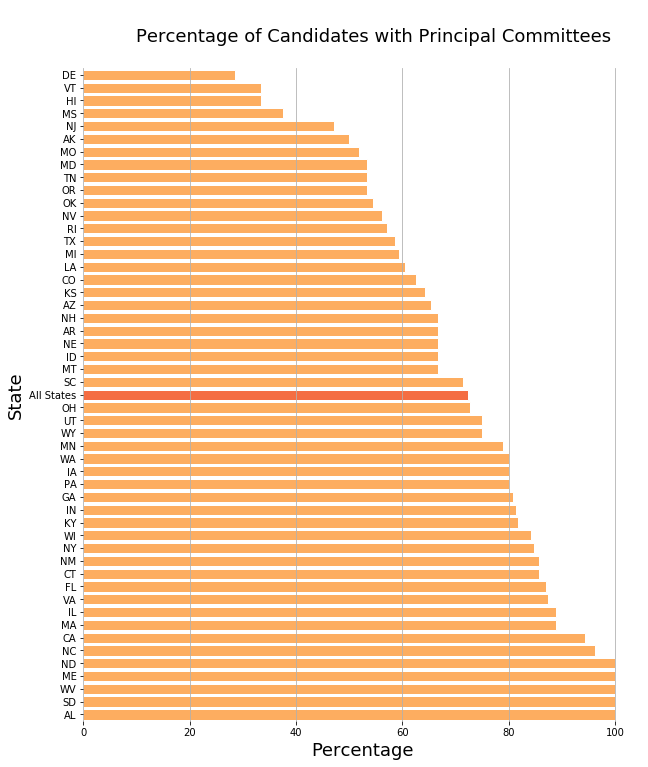

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12), sharex=True)
fig.patch.set_facecolor('w')

ge_cand_percent = ge_cand_percent.sort_values('GE_PC_%')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.barh(y=ge_cand_percent['State'], 
        width=ge_cand_percent['GE_PC_%'],
        color=palette[3], edgecolor='white')

ax.barh(y='All States',
        width=100*ge_cand_percent['GE_PC'].sum()/\
                                ge_cand_percent['GE_Candidates'].sum(),
        color=palette[2], edgecolor='white')

ax.set_ylim(-0.5, 50.5)

ax.grid(axis='x')

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Percentage of Candidates with Principal Committees
    ''', fontdict=font)

ax.invert_yaxis()

plt.savefig('graphs/cands_pc_%.png', dpi=300, bbox_inches='tight')
plt.show();

## Obtaining Financial Reports for Each Principal Committee

In [24]:
financial_reports = pd.read_csv('data/financial_reports_house_2016.csv')

In [25]:
df_form3 = pd.DataFrame()

for state in states_and_districts():
    df_state = results_pc[(results_pc['STATE_ABBREVIATION'] == state) & 
                          (results_pc['GENERAL_VOTES'].notnull())]    
    form3_count = 0
    
    for com in df_state['COMMITTEE_ID']:
        if com in financial_reports['committee_id'].unique():
            form3_count += 1

    df_form3 = df_form3.append({'State' : state,
                                'GE_Form3' : form3_count}, 
                                ignore_index=True)

df_form3 = df_form3.append({'State' : 'All States',
                            'GE_Form3' : df_form3['GE_Form3'].sum()},
                          ignore_index=True)    

ge_cand_percent = ge_cand_percent.merge(df_form3, on='State')

In [26]:
# create a column representing the percentage of GE candidates who filed at least one FEC Form 3
ge_cand_percent['GE_Form3_%'] = 100*ge_cand_percent['GE_Form3'] / ge_cand_percent['GE_Candidates']

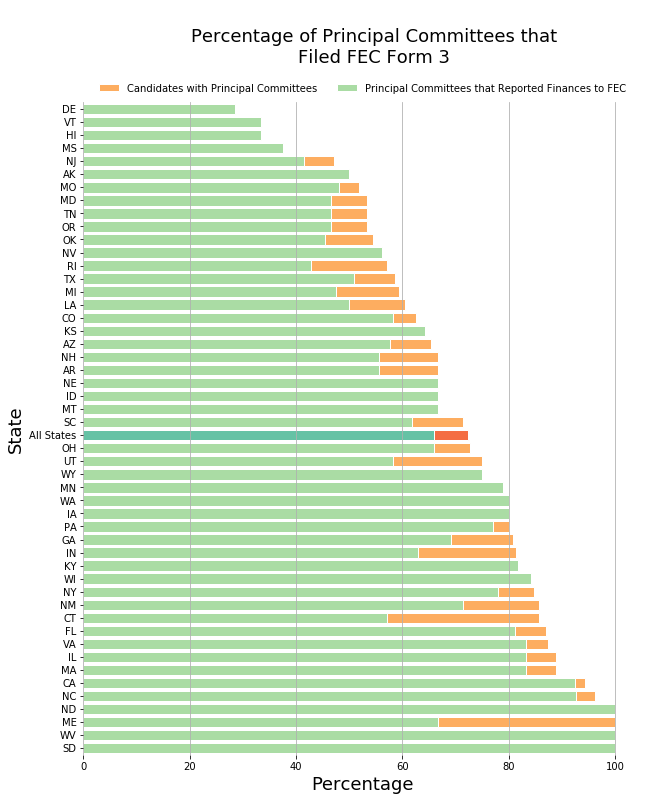

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12), sharex=True)
fig.patch.set_facecolor('w')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.barh(y=ge_cand_percent['State'], width=ge_cand_percent['GE_PC_%'],
        left=0, 
        color=palette[3], edgecolor='white',
        label='Candidates with Principal Committees')

ax.barh(y=ge_cand_percent['State'], width=ge_cand_percent['GE_Form3_%'],
        left=0, 
        color=palette[7], edgecolor='white',
        label='Principal Committees that Reported Finances to FEC')

ax.barh(y='All States',
        width=100*ge_cand_percent['GE_PC'].sum()/\
                                ge_cand_percent['GE_Candidates'].sum(),
        color=palette[2], edgecolor='white')

ax.barh(y='All States',
        width=100*ge_cand_percent['GE_Form3'].sum()/\
                                ge_cand_percent['GE_Candidates'].sum(),
        color=palette[8], edgecolor='white')

ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

ax.set_ylim(-0.5, 49.5)

ax.grid(axis='x')

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Percentage of Principal Committees that
    Filed FEC Form 3
    ''', fontdict=font, y=1.02)

ax.invert_yaxis()

plt.savefig('graphs/cands_form3_%.png', dpi=300, bbox_inches='tight')
plt.show();

In [28]:
# all relevant columns from 'financial_reports' as they relate to funds raised
funds_raised = [
    'individual_itemized_contributions_period',
    'individual_unitemized_contributions_period',
    'candidate_contribution_period',
    'political_party_committee_contributions_period',
    'other_political_committee_contributions_period',
    'transfers_from_other_authorized_committee_period',
    'loans_made_by_candidate_period',
    'all_other_loans_period',
    'offsets_to_operating_expenditures_period',
    'other_receipts_period',
    'total_receipts_period'
]

# all relevant columns from 'financial_reports' as they relate to funds spent
funds_spent = [
    'operating_expenditures_period',
    'transfers_to_other_authorized_committee_period',
    'refunded_individual_contributions_period',
    'refunded_political_party_committee_contributions_period',
    'refunded_other_political_committee_contributions_period',
    'loan_repayments_candidate_loans_period',
    'loan_repayments_other_loans_period',
    'other_disbursements_period',
    'total_disbursements_period'
]

In [29]:
def fc_total_per_com(committee_id, financial_category):
# committee_id as a string representing the committee ID 
# financial_category as a string from one of the columns from 'financial_reports'
# return the total for that category over the course of the whole election cycle

    return financial_reports[financial_reports['committee_id'] == committee_id]\
                [financial_category].sum()

In [30]:
# Determine the totals for each of the categories related to funds raised (aka receipts) 
# for each of the candidate and a create a new dataframe which contains these totals plus
# information about the candidate and their election results

fr_com = pd.DataFrame()

for com in results_pc['COMMITTEE_ID'].unique():
    df_temp = pd.DataFrame({'COMMITTEE_ID' : [com]})
    
    for fr in funds_raised:
        fct = fc_total_per_com(com, fr)
        fr_col = fr.replace('_period', '').upper()
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fr_col : [fct]})], axis=1)
    
    fr_com = pd.concat([fr_com, df_temp])

results_pc_fr = results_pc.merge(fr_com, on='COMMITTEE_ID')

In [31]:
# Determine the totals for each of the categories related to funds spent (aka disbursements) 
# for each of the candidate and a create a new dataframe which contains these totals plus
# information about the candidate and their election results

fs_com = pd.DataFrame()

for com in results_pc['COMMITTEE_ID'].unique():
    df_temp = pd.DataFrame({'COMMITTEE_ID' : [com]})
    
    for fs in funds_spent:
        fct = fc_total_per_com(com, fs)
        fs_col = fs.replace('_period', '').upper()
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fs_col : [fct]})], axis=1)
    
    fs_com = pd.concat([fs_com, df_temp])

results_pc_fs = results_pc.merge(fs_com, on='COMMITTEE_ID')

In [32]:
# calculate the number of candidates who spent the most money during the campaign 
# and then won the general election 
n_max_funds_win_all = {}
spent_per_com = pd.DataFrame()

for state in states_and_districts():
    # select only candidates from 'state' who appeared in the General Election
    df_state = results_pc_fs[(results_pc_fs['STATE_ABBREVIATION'] == state) & 
                             (results_pc_fs['GENERAL_VOTES'].notnull())]
    n_max_funds_win = 0
    
    # each district in each state
    for d in df_state['D'].unique():
        # determine the index of the candidate who spent the most money
        idx_max_funds = df_state[df_state['D'] == d]['TOTAL_DISBURSEMENTS'].idxmax()
        n_max_funds_win += results_pc_fs.loc[idx_max_funds, 'GE_WINNER_INDICATOR']
    
    n_max_funds_win_all[state] = n_max_funds_win

win_loss_per_state = pd.DataFrame()

# create dataframe with win and loss percentages for each state 
for state in states_and_districts():   
    win_percent = (n_max_funds_win_all[state]/states_and_districts()[state])*100
    loss_percent = (100 - win_percent)
    
    win_loss_per_state = win_loss_per_state.append({'State' : state,
                                                    'Win_Percent' : win_percent,
                                                    'Loss_Percent' : loss_percent},
                                                  ignore_index=True)

In [33]:
as_win_percent = 100*sum(n_max_funds_win_all.values())/sum(states_and_districts().values())
as_loss_percent = (100 - as_win_percent)

win_loss_per_state = win_loss_per_state.append({'State' : 'All States',
                                                'Win_Percent' : as_win_percent,
                                                'Loss_Percent' : as_loss_percent},
                                              ignore_index=True)

In [34]:
print('In {} of states, all of the candidate who spent the most money also won the election.'
      .format(win_loss_per_state\
              [win_loss_per_state['Win_Percent'] == 100]['Win_Percent'].count()))

print('In {} of states, 80% of the candidate who spent the most money also won the election.'
      .format(win_loss_per_state\
              [win_loss_per_state['Win_Percent'] >= 80]['Win_Percent'].count()))


In 29 of states, all of the candidate who spent the most money also won the election.
In 44 of states, 80% of the candidate who spent the most money also won the election.


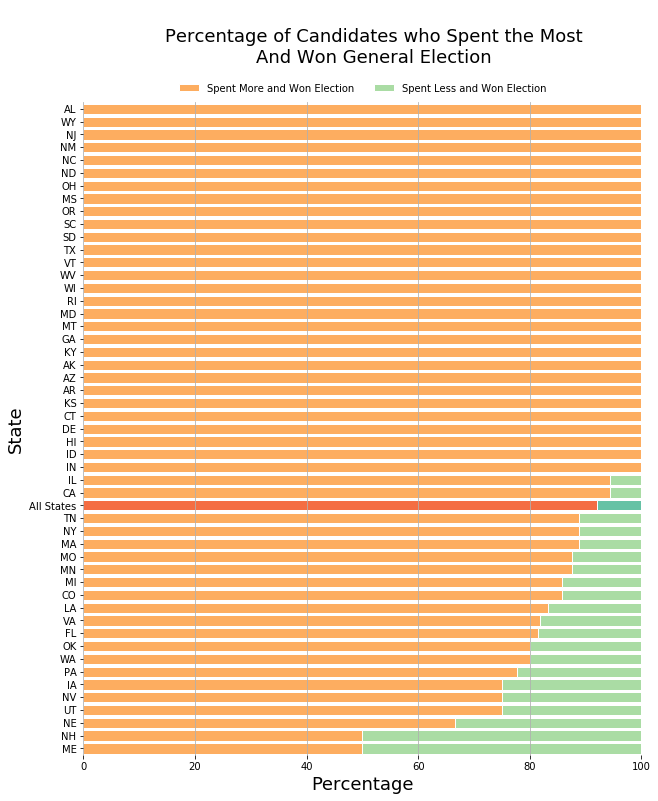

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12), sharex=True)
fig.patch.set_facecolor('w')

win_loss_per_state = win_loss_per_state.sort_values('Loss_Percent')

ax.barh(win_loss_per_state['State'], win_loss_per_state['Win_Percent'],
        color=palette[3], edgecolor='white',
        label='Spent More and Won Election')

ax.barh(win_loss_per_state['State'], win_loss_per_state['Loss_Percent'], 
        left=win_loss_per_state['Win_Percent'],
        color=palette[7], edgecolor='white',
        label='Spent Less and Won Election')

ax.barh(y='All States',
        width=as_win_percent,
        color=palette[2], edgecolor='white')

ax.barh(y='All States', 
        width=as_loss_percent, 
        left=as_win_percent,
        color=palette[8], edgecolor='white')

ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(-0.5, 50.5)

ax.grid(axis='x')

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Percentage of Candidates who Spent the Most
    And Won General Election
    ''', fontdict=font, y=1.02)

ax.invert_yaxis()

plt.savefig('graphs/spent_more_and_won.png', dpi=300, bbox_inches='tight')
plt.show();

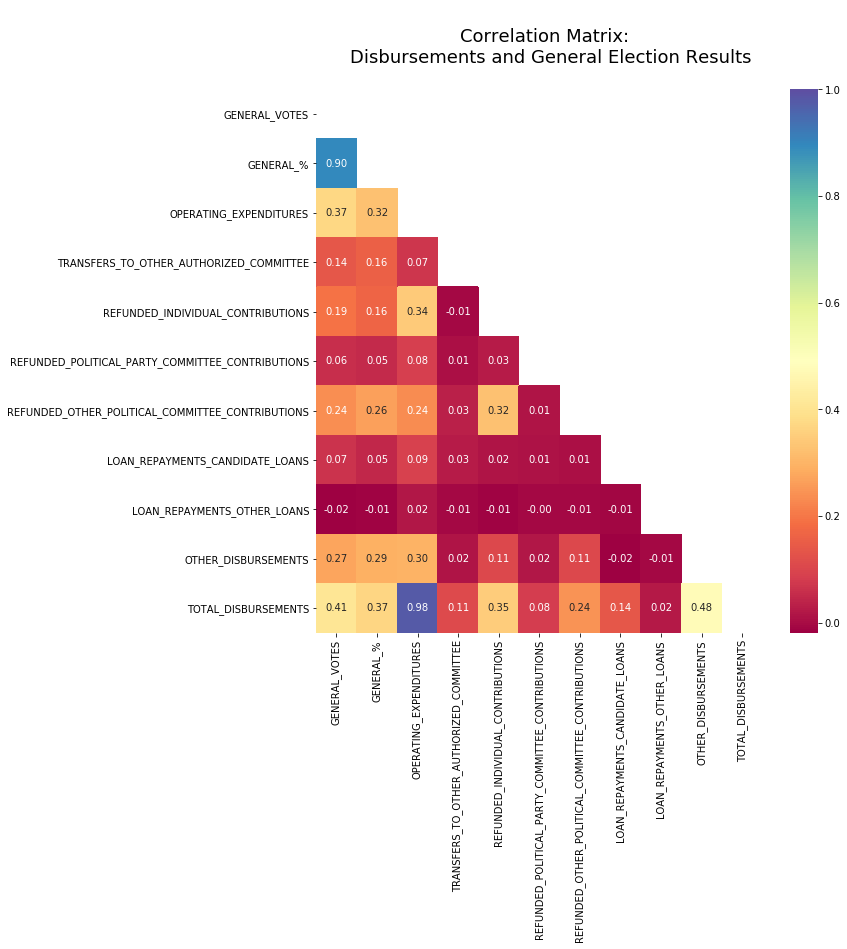

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

drop_cols = ['D', 'INCUMBENT', 'PRIMARY_VOTES', 'PRIMARY_%', 'GE_WINNER_INDICATOR']

corr = results_pc_fs.drop(drop_cols, axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f");

ax.set_title('''
    Correlation Matrix:  
    Disbursements and General Election Results
    ''', fontdict=font, y=1.02)

plt.savefig('graphs/corr_matrix_fs.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
def plot_scatter(ax, df1, df2, nrows, y, xlist, title):
    # pass the axes object 
    # df1 represents those candidates that won
    # df2 represents those candidates that lost
    # nrows and len(xlist) should be the same
    # y is the variable of interest, in this case 'GENERAL_VOTES'
    
    for r in range(0, nrows):
        
        won = ax[r].scatter(x=df1[xlist[r]], y=df1[y],
                     c=[palette[3]], s=30);
        lost = ax[r].scatter(x=df2[xlist[r]], y=df2[y],
                      c=[palette[7]], s=30);
    
        ax[r].spines['right'].set_visible(False)
        ax[r].spines['top'].set_visible(False)

        ax[r].tick_params(axis='both',
                          bottom=False,
                          left=False,
                          labelbottom=False,
                          labelleft=False)
    
        ax[r].set_xlim(0,8500000)

        # turn off scientific notation
        ax[r].ticklabel_format(style='plain')

        ax[r].set_xlabel('{} ($)'.format(xlist[r]), fontdict=font)
        ax[r].set_ylabel('{} (count)'.format(y), fontdict=font)


    ax[0].legend((won,lost), ('Won', 'Lost'), ncol=2, bbox_to_anchor=(0.5, 1), 
                loc='lower center', frameon=False)
    
    ax[0].set_title(title, fontdict=font, y=1.04)
    
    # reduce spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0.1)
    
    title = title.replace(' ', '_').strip().lower()
    plt.savefig('graphs/{t}.png'.format(t=title), dpi=300, bbox_inches='tight')
    plt.show()

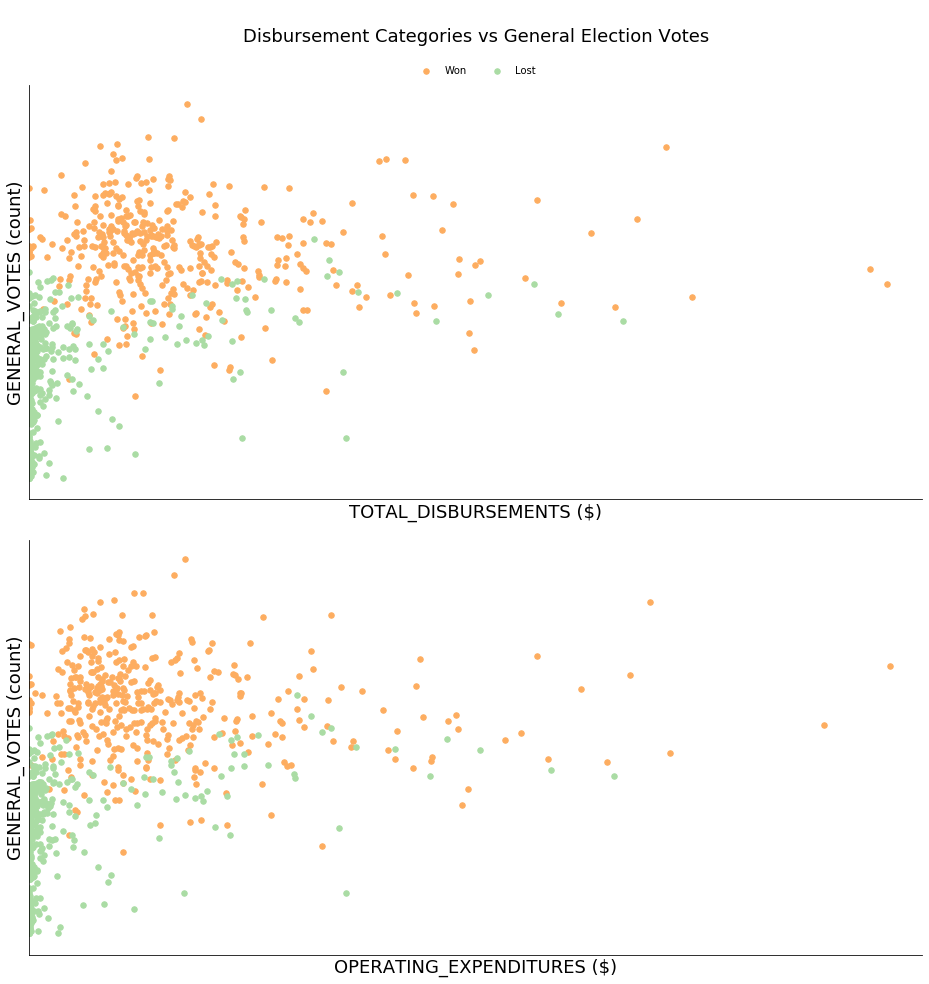

In [47]:
won_ge = results_pc_fs[(results_pc_fs['GENERAL_%'].notnull()) &
                       (results_pc_fs['GE_WINNER_INDICATOR'] == 1)]
lost_ge = results_pc_fs[(results_pc_fs['GENERAL_%'].notnull()) &
                       (results_pc_fs['GE_WINNER_INDICATOR'] == 0)]

xlist = ['TOTAL_DISBURSEMENTS', 'OPERATING_EXPENDITURES']
nrows = len(xlist)
title = \
'''
Disbursement Categories vs General Election Votes
'''

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16,16))
fig.patch.set_facecolor('w')

plot_scatter(ax, won_ge, lost_ge, nrows, 'GENERAL_VOTES', xlist, title)

In [39]:
def plot_sum_of_categories(ax, df, cat_list, title):
    state_list = []
    for st in states_and_districts():
        state_list.append(st)

    data = df[cat_names].values
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap(cmap)(np.linspace(0.15, 0.85, data.shape[1]))

    for i, (colname, color) in enumerate(zip(cat_names, category_colors)):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            ax.barh(state_list, widths, left=starts,
                    label=colname, color=color)

    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

    ax.set_ylim(-0.5, 49.5)
    ax.invert_yaxis()

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlabel('Percentage', fontdict=font)
    ax.set_ylabel('State', fontdict=font)
    ax.set_title(title, fontdict=font, y=1.06)

    ax.grid(axis='x')

    title = title.replace(' ', '_').strip().lower()
    plt.savefig('graphs/{t}.png'.format(t=title), dpi=300, bbox_inches='tight')    
    plt.show();

In [40]:
# calculate the percentage each category in funds_spent accounts for 'Total Disbursements'
fsp_per_state = pd.DataFrame()

for state in states_and_districts():
    df_temp = pd.DataFrame({'STATE' : [state]})
    
    for fs in funds_spent[:-1]:
        fs_col = fs.replace('_period', '').upper()
        
        fs = results_pc_fs[results_pc_fs['STATE_ABBREVIATION'] == state][fs_col].sum()
        fsp = 100*fs/results_pc_fs[results_pc_fs['STATE_ABBREVIATION'] == state]\
                                                ['TOTAL_DISBURSEMENTS'].sum()        
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fs_col : [fsp]})], axis=1)
    
    fsp_per_state = pd.concat([fsp_per_state, df_temp])

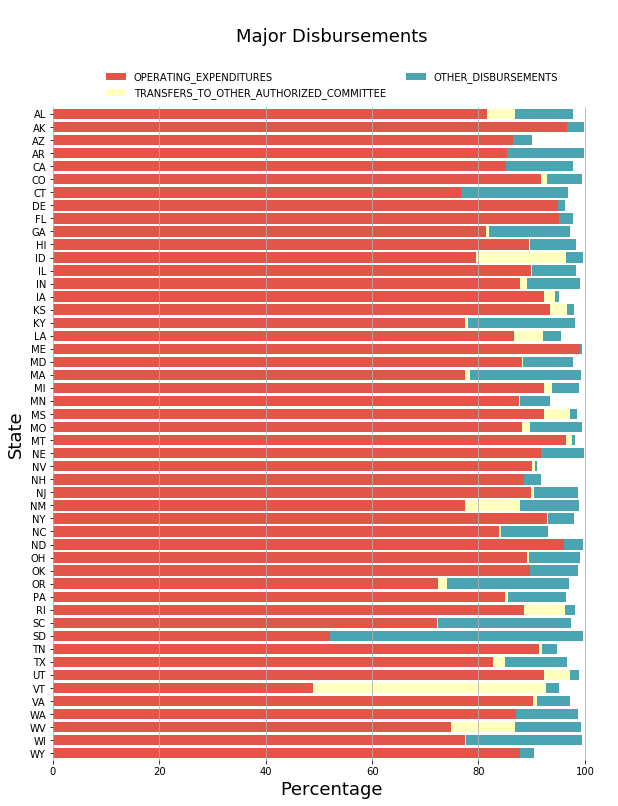

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12), sharex=True)
fig.patch.set_facecolor('w')

# only include contribution columns 
# (exclude 'Transfers from other authorized committes', 'loans made by candidates',
# 'other loans', 'offsets to operating expenditures', and 'other receipts')
cat_names = []
# exclude load repayments and refunds
fs_cats = [funds_spent[i] for i in (0,1,7)]
for fs in fs_cats:
    cat_names.append(fs.replace('_period', '').upper())
    
title = '''
Major Disbursements
'''
    
plot_sum_of_categories(ax, fsp_per_state, cat_names, title)

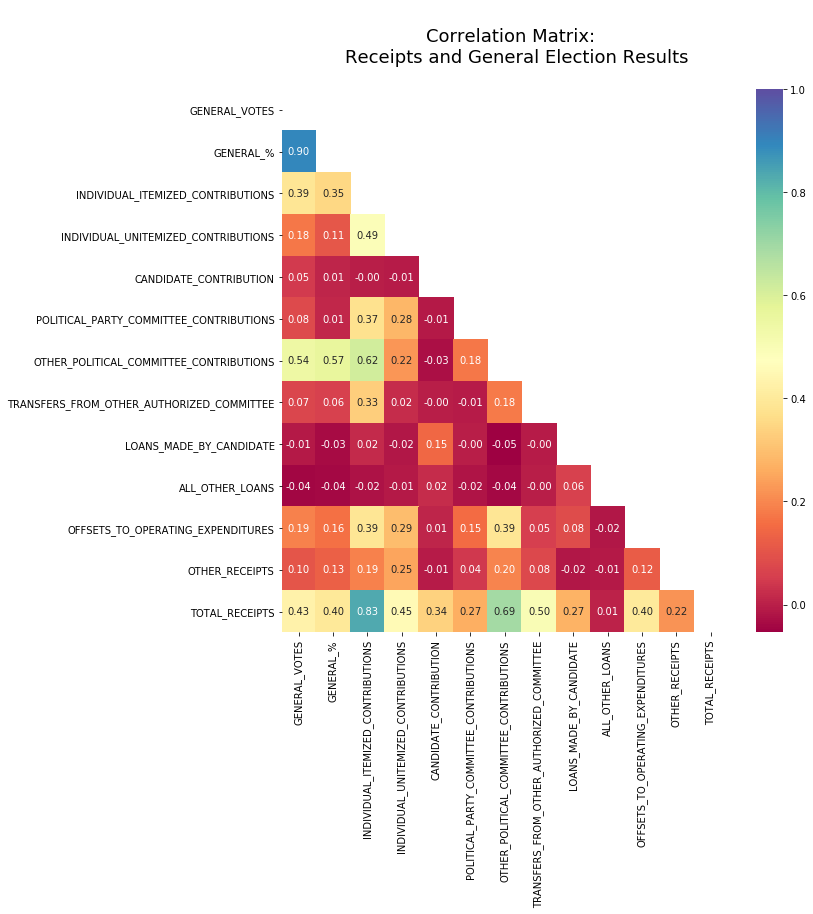

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

drop_cols = ['D', 'INCUMBENT', 'PRIMARY_VOTES', 'PRIMARY_%', 'GE_WINNER_INDICATOR']

corr = results_pc_fr.drop(drop_cols, axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f");

ax.set_title('''
    Correlation Matrix:  
    Receipts and General Election Results
    ''', fontdict=font, y=1.02)

plt.savefig('graphs/corr_matrix_fr.png', dpi=300, bbox_inches='tight')
plt.show()

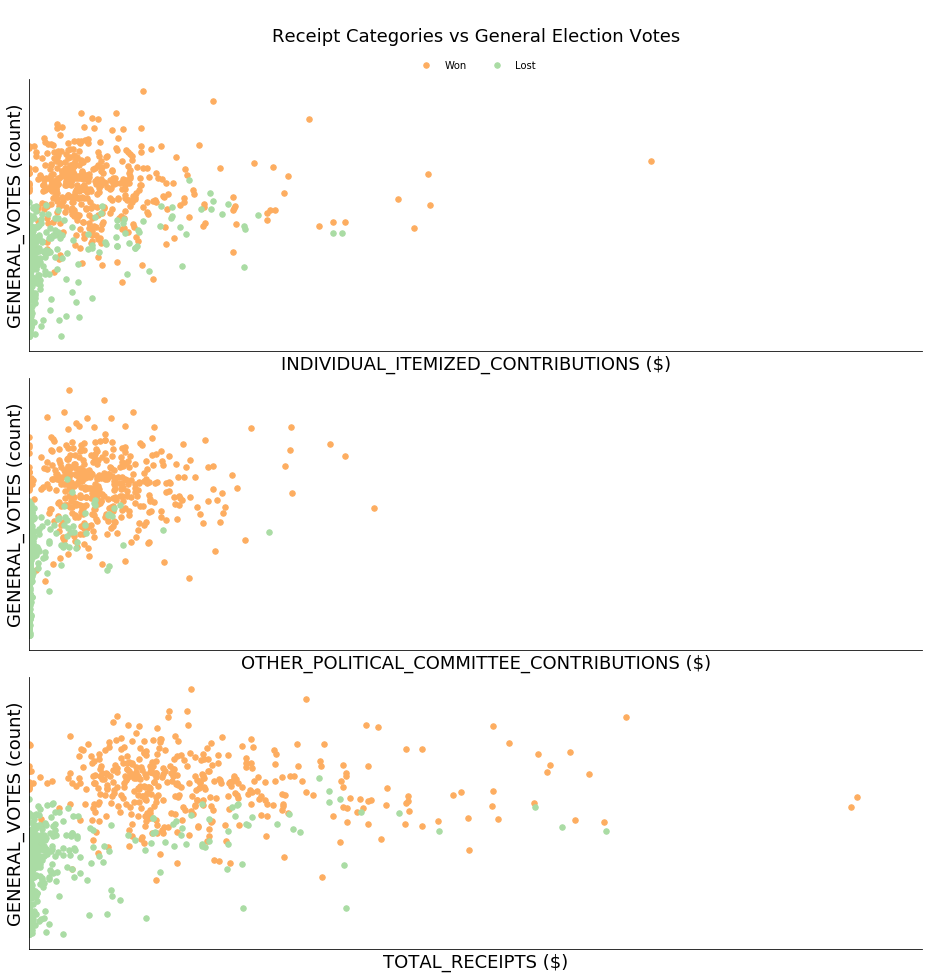

In [48]:
won_ge = results_pc_fr[(results_pc_fr['GENERAL_%'].notnull()) &
                       (results_pc_fr['GE_WINNER_INDICATOR'] == 1)]
lost_ge = results_pc_fr[(results_pc_fr['GENERAL_%'].notnull()) &
                       (results_pc_fr['GE_WINNER_INDICATOR'] == 0)]

xlist = ['INDIVIDUAL_ITEMIZED_CONTRIBUTIONS', 'OTHER_POLITICAL_COMMITTEE_CONTRIBUTIONS',
         'TOTAL_RECEIPTS']
nrows = len(xlist)
title = \
'''
Receipt Categories vs General Election Votes
'''

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16,16))
fig.patch.set_facecolor('w')

plot_scatter(ax, won_ge, lost_ge, nrows, 'GENERAL_VOTES', xlist, title)

In [44]:
# calculate the financial contribution percentage of each category in funds_raised
frp_per_state = pd.DataFrame()

for state in states_and_districts():
    df_temp = pd.DataFrame({'STATE' : [state]})
    
    for fr in funds_raised[:-1]:
        fr_col = fr.replace('_period', '').upper()
        
        fr = results_pc_fr[results_pc_fr['STATE_ABBREVIATION'] == state][fr_col].sum()
        frp = 100*fr/results_pc_fr[results_pc_fr['STATE_ABBREVIATION'] == state]\
                                                ['TOTAL_RECEIPTS'].sum()        
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fr_col : [frp]})], axis=1)
    
    frp_per_state = pd.concat([frp_per_state, df_temp])

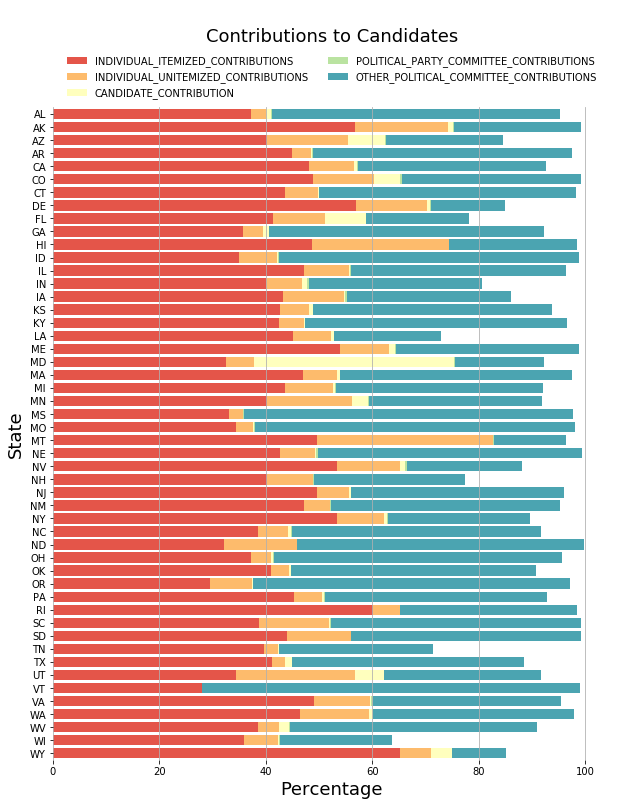

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12), sharex=True)
fig.patch.set_facecolor('w')

# only include contribution columns 
# (exclude 'Transfers from other authorized committes', 'loans made by candidates',
# 'other loans', 'offsets to operating expenditures', and 'other receipts')
cat_names = []
for fr in funds_raised[:5]:
    cat_names.append(fr.replace('_period', '').upper())
    
title = '''
Contributions to Candidates
'''
    
plot_sum_of_categories(ax, frp_per_state, cat_names, title)